In [7]:
push!(LOAD_PATH, pwd()*"/..")
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions

In [6]:
N = 400
kbar = 10
sigmak = 0.6
# tdp = compute_two_degree_params(kbar,sigmak)
# println(tdp)
# compute_k_sigma_k(tdp)
g = graph_from_two_degree_distribution(N,kbar,sigmak)
# g = graph_from_gamma_distribution(N,kbar,sigmak)
dg = degree(g)
println(mean(dg), " " , std(dg))
# println(dg)

10.02 1.001052078144735


We imagine a graph with a degree distribution made up as
$$P(k') = p_1 \delta(k_1 - k') + p_2 \delta(k_2 - k')$$
, i.e. only two degrees are allowed, one lower (1) and one higher (2). This means that
$$\bar{k} = p_1 k_1 + p_2 k_2$$
and
$$Var[k] = p_1 k_1^2 + p_2 k_2^2 - \bar{k}^2$$

In order to find the death and birth rates, we need to find the distribution of $\tilde{y}_k$, i.e. the value of $y$ as seen by a given node of degree $k$.

Now, for a node of degree $k'$, it will have $k_1'$ edges to other nodes of degree $k_1$, and $k_2' = k' - k_1'$ edges to other nodes of degree $k_2$. $k_1'$ is distributed as
$$k_1' \sim Binom(k,p_{1|k})$$
where $p_{k''|k}$ is the neighbor degree distribution, and $p_{1|k}$ is the probability that a neighboring node has the lower degree $k_1$. We will assume that $p_{k''|k} = \frac{k'' p_{k''}}{\bar{k}}$

Given $k_1'$, the number of infecteds seen among those edges leading to other nodes of degree $k_1$ is given by
$$i_{1|k} \sim Binom(k_1',y_1)$$
$$i_{2|k} \sim Binom(k - k_1',y_2)$$
where $y_1 = n_1/N_1$ is the fraction of lower degree nodes that are currently infected.

Thus we have
$\tilde{y}_k = \frac{i_{1|k} + i_{2|k}}{k_1' + k_2'} =\frac{i_{1|k} + i_{2|k}}{k} $
We calculate the expectations of $\tilde{y}_k$ by first computing the expectations conditioned on $k_1'$, and then taking expectations over the distribution of $k_1'$ (Law of Total Expectation).

The expectations of $k_1'$ and $k_1'^2$ are 
$$E[k_1'] = k p_{1|k}$$
$$E[k_1'^2] = k^2 p_{1|k}^2 + k p_{1|k} (1 - p_{1|k})$$


We thus obtain
$$E[i_{1|k} | k_1'] = k_1' y_1$$
$$E[i_{1|k}] = k p_{1|k} y_1$$
and therefore
$$E[\tilde{y}_k] = p_{1|k} y_1 + p_{2|k} y_2$$

Similarly, we have
$$E[\tilde{y}^2_k] =  \frac{1}{k^2} \left( k_1'^2 y_1^2 + k_1' y_1 (1- y_1) + 2 y_1 y_2 (k k_1' - k_1'^2) + (k^2 - 2 k k_1' + k_1'^2) y_2^2 + (k - k_1') y_2 (1 - y_2)  \right)$$
where we replace all instances of $k_1'$ and $k_1'^2$ with their expectations to obtain the final expression as a function of only $y_{1/2}$ and $p_{1/2 | k}$.


In [ ]:
function compute_k_sigma_k(tdp::TwoDegreeParams)
    p1 = tdp.p1
    p2 = tdp.p2
    k1 = tdp.k1
    k2 = tdp.k2
    
    k_bar = p1*k1 + p2*k2
    sigma_k = (p1*k1^2 + p2*k2^2 - k_bar^2)^(0.5)
    println("k_bar: $(k_bar), sigma_k: $(sigma_k)")
end

In [9]:
p_1 = 0.5
p_2 = 0.5
k_1 = 5
k_2 = 21
tdp = TwoDegreeParams(k_1,k_2,p_1,p_2)
N = 99

99

In [10]:
g = graph_from_two_degree_distribution(tdp,40)
p_k = get_p_k_two_degree(p_1,k_1,p_2,k_2)
degrees = get_degrees_from_p_k(p_k,N)

k_bar: 13.0, sigma_k: 8.0


LoadError: UndefVarError: Multinomial not defined

## Run a well mixed simulation keeping track of $n_1$ and $n_2$

In [245]:
### Well Mixed Case ###
function run_epidemic_well_mixed_two_degree(N,alpha,beta,tdp,fixation_threshold=1.0)
    n1 = 0
    n2 = 0
    dt = 0.01
    if rand() < tdp.p1
        n1 = 1
    else
        n2 = 1
    end
    infecteds::Array{Float64,1} = []
    tuples::Array{Tuple{Float64,Float64,Float64},1} = []
    n = n1 + n2
    fixed=false
    push!(infecteds,n)
    push!(tuples,create_tuple(n,n1,n2,N,tdp))


    while n > 0
        if !(n < N && n < N*fixation_threshold)
            fixed = true
            break
        end
        n1,n2 = update_n_two_degree(n1,n2,N,alpha,beta,tdp,dt)
        n = n1 + n2
        push!(infecteds,n)
        push!(tuples,create_tuple(n,n1,n2,N,tdp))
    end

    size = dt*sum(infecteds)
    if fixed
        size = Inf
    end

    return EpidemicRun(infecteds,size,fixed),tuples
end

function create_tuple(n,n1,n2,N,tpd)
    N1 = Int(round(tdp.p1*N))
    N2 = N-N1
    return (n/N,n1/N1,n2/N2)
end



function get_p_neighbor(tdp)
    p1 = tdp.p1
    p2 = tdp.p2
    k1 = tdp.k1
    k2 = tdp.k2
    p1k = k1*p1/(k1*p1 + k2*p2)
    p2k = k2*p2/(k1*p1 + k2*p2)
    return p1k,p2k
end


function update_n_two_degree(n1::Int,n2::Int,N::Int,alpha,beta,tdp,dt)
    p1 = tdp.p1
    p2 = tdp.p2
    k1 = tdp.k1
    k2 = tdp.k2
    N1 = Int(round(tdp.p1*N))
    N2 = N-N1
    n = n1 + n2
    y = n/N
    y_tilde = get_mean_y_tilde(n1,n2,N1,N2,tdp)
    y_tilde_sq1 = get_mean_y_tilde_sq(k1,n1,n2,N1,N2,tdp)
    y_tilde_sq2 = get_mean_y_tilde_sq(k2,n1,n2,N1,N2,tdp)
    
    
    delta_n_plus1 = rand(Binomial(N1-n1,dt*(y_tilde + alpha*y_tilde_sq1)))
    delta_n_minus1 = rand(Binomial(n1,dt*(1-y_tilde)*(1 + beta)))
    
    delta_n_plus2 = rand(Binomial(N2-n2,dt*(y_tilde + alpha*y_tilde_sq2)))
    delta_n_minus2 = rand(Binomial(n2,dt*(1-y_tilde)*(1 + beta)))
    
    n1 = n1 + delta_n_plus1 - delta_n_minus1
    n2 = n2 + delta_n_plus2 - delta_n_minus2
    
    n1 = clamp(n1,0,N1)
    n2 = clamp(n2,0,N2)
#     y_desired = (n1+n2)/N
#     if y_desired > 0.08
#         n1 = Int(round(y_desired*N1))
#         n2 = Int(round(y_desired*N2))
#     end
    return n1,n2
end

function get_mean_y_tilde(n1,n2,N1,N2,tdp)
    y1 = n1/N1
    y2 = n2/N2
    p1k,p2k = get_p_neighbor(tdp)
    return p1k*y1 + p2k*y2
end

function get_mean_y_tilde_sq(k,n1,n2,N1,N2,tdp)
    y1 = n1/N1
    y2 = n2/N2
    p1k,p2k = get_p_neighbor(tdp)
    mean_k1sq = k^2*p1k^2 + k*p1k*(1-p1k)
    mean_k1 = k*p1k
    denom = mean_k1sq*y1^2 + mean_k1*y1*(1-y1) +
    2*(mean_k1*k - mean_k1sq)*y1*y2
    (k^2-2*mean_k1*k + mean_k1sq)*y2^2+
    (k-mean_k1)*y2*(1-y2)
    return denom/k^2
end
    
function get_p_reach_well_mixed_two_degree_simulation(alpha,beta,N,tdp,num_runs=10000)
    runs,tuples = run_epidemics_two_degree(num_runs, () -> run_epidemic_well_mixed_two_degree(N,alpha,beta,tdp,1.0));
    yy,pp = get_p_reach(runs,N)
    return yy,pp,tuples
end

function run_epidemics_two_degree(num_runs::Int,run_epidemic_fn)
    runs = EpidemicRun[]
    tuples_arr::Array{Array{Tuple{Float64,Float64,Float64},1}} = []

    for i in 1:num_runs
        run,tuples = run_epidemic_fn()
        push!(runs,run)
        push!(tuples_arr,tuples)
    end
    all_tuples = vcat(tuples_arr...)
    #get rid of fixed oneus

    return runs,all_tuples
end



run_epidemics_two_degree (generic function with 1 method)

In [246]:
function compute_y1_y2_vs_y(tuples,N)
    y_arr = collect(0:1/N:1)
    y_count = zeros(N+1)
    y1_arr = zeros(N+1) 
    y2_arr = zeros(N+1) 
    for tuple in tuples
        y = tuple[1]
        y1 = tuple[2]
        y2 = tuple[3]
        idx = 1+Int(round(y*N))
        y_count[idx] += 1
        y1_arr[idx] += y1
        y2_arr[idx] += y2
    end
    y_count[y_count .== 0] = 1
    return y_arr, y1_arr ./ y_count, y2_arr ./y_count
end

function compute_y1_y2_vs_y(y_0,tuples,N,tol =0)
    if tol == 0
        tol = 1/N
    end
    count = 0
    y1_tot= 0
    y2_tot= 0
    for tuple in tuples
        y = tuple[1]
        y1 = tuple[2]
        y2 = tuple[3]
        if y_0 - tol <= y <= y_0 + tol
            y1_tot += y1
            y2_tot += y2
            count += 1
        end
    end
    return count,y1_tot/count,y2_tot/count 
end



compute_y1_y2_vs_y (generic function with 3 methods)

In [254]:
N = 2000
k = 10
sigmak = 20

trials = 100000

tdp = compute_two_degree_params(k,sigmak)


y_n = 0.2
c_r = 0.2#0.18
n_n = y_n*N#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
# alpha,beta = 0.0,0.0
println("N=$N, alpha = $alpha, beta = $beta")

# im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

yy,pp,tuples = get_p_reach_well_mixed_two_degree_simulation(alpha,beta,N,tdp,trials)
println(length(tuples))

N=2000, alpha = 0.25, beta = 0.05
18685118


In [255]:
y_arr,y1_arr,y2_arr = compute_y1_y2_vs_y(tuples,N)

([0.0,0.0005,0.001,0.0015,0.002,0.0025,0.003,0.0035,0.004,0.0045  …  0.9955,0.996,0.9965,0.997,0.9975,0.998,0.9985,0.999,0.9995,1.0],[0.0,0.000551156,0.0010628,0.00153953,0.00201327,0.00250302,0.00299694,0.00349019,0.00398653,0.004481  …  0.995182,0.99571,0.996291,0.996818,0.997424,0.997786,0.998352,0.998884,0.999439,1.0],[0.0,8.39792e-5,0.00048925,0.00117855,0.00189207,0.00247541,0.00302492,0.00357979,0.00410951,0.00465448  …  0.998089,0.998356,0.998203,0.998478,0.998115,0.999738,0.9997,0.999941,1.0,1.0])

In [256]:
compute_y1_y2_vs_y(0.7,tuples,N,5/N)

(378,0.6993678125064989,0.7027856297262686)

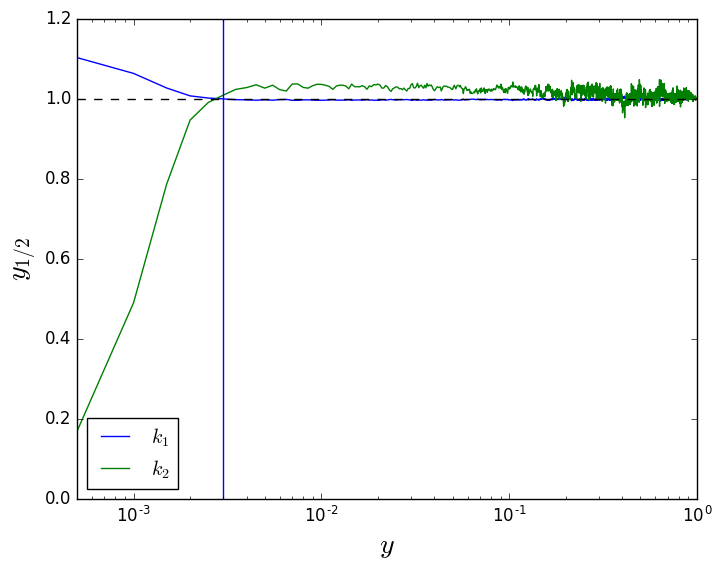

PyObject <matplotlib.lines.Line2D object at 0x334bc60d0>

In [269]:
semilogx(y_arr,y1_arr./y_arr,label=L"k_1")
plot(y_arr,y2_arr./y_arr,label=L"k_2")
axhline(1,color="k",linestyle="--")
legend(loc="best")
xlabel(L"y",size=20)
ylabel(L"y_{1/2}",size=20)
xlim([1/N,1])
axvline(3e-3)

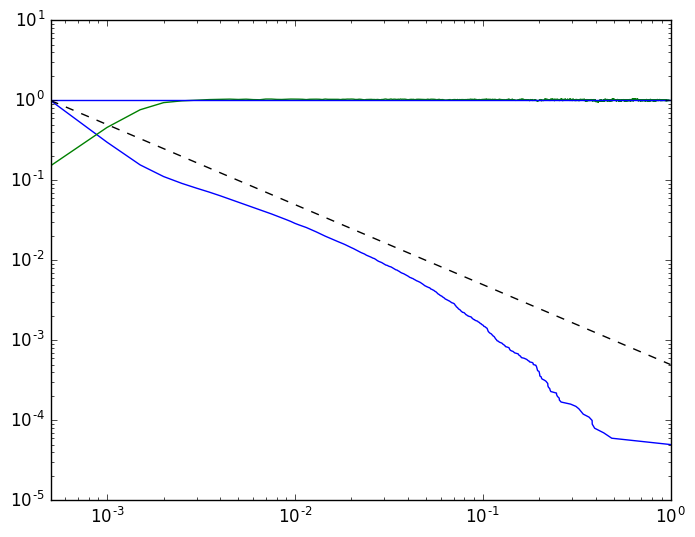

PyObject <matplotlib.lines.Line2D object at 0x335c84710>

In [273]:
loglog(yy,pp)
plot(y_arr,y2_arr./y1_arr,label=L"k_2")
# loglog(yy1,pp1)
loglog(yy,1./(N*yy),"--k")
xlim([1/N,1])
axhline(1)

We see that the two degree simulation captures the dynamics at least qualitatively.


Look at the distribution of $n1$ and $n2$ as a function of $y$

The probability of having $n_2$ be high is first low (of course, because the first node is likely to be $n_1$, and then rises to be $n_2$).

can we use the diffusion equation to find the average $n_1$ and $n_2$ conditioned on reaching that $y$, and then develop an effective $s$ based on those distributions of $n_1$ and $n_2$?

How do we maybe solve for the average $n_1$ and $n_2$??


Maybe I need to condition on non-extinction but then observe the $y_{1/2}$ distribution for $y$ _below_ the current $y$! Maybe the distribution has equalized out by the time we look at it, but it was uneven before!


Other questions
- what do we do with this?
- Can we solve the 2D diffusion equation to get expressions for p_reach, etc?
- What are the orthogonal directions?
- Try this on larger simulation data sets, quantitatively